# Notebook 01 – Data Exploration

This notebook performs an initial exploration of the German Credit dataset.  
Objectives:  
- Inspect target distribution and assess class imbalance.  
- Identify feature types (numeric vs categorical).  
- Separate categorical features into simple vs complex (for preprocessing).  
- Check for missing values.  
- Review distributions of numeric variables.  

The outcome is a set of feature group definitions (`num_cols`, `simple_cat_cols`, `complex_cat_cols`) saved as configuration for downstream pipeline components.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure plots display nicely
%matplotlib inline
sns.set(style="whitegrid")

# Load dataset (assuming dataset is at project root)
df = pd.read_csv("../german_credit.csv")

df.head()

,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,Employment,InstallmentRate,SexAndStatus,OtherDetors,...,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,PeopleLiable,Telephone,ForeignWorker,CreditRisk
0,< 0 DM,6,critical account/other credits existing,radio/TV,1169,unknown/none,≥ 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee/official,1,"yes, registered under customer’s name",yes,0
1,0 ≤ balance < 200 DM,48,existing credits paid duly till now,radio/TV,5951,< 100 DM,1 ≤ ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee/official,1,none,yes,1
2,no checking account,12,critical account/other credits existing,education,2096,< 100 DM,4 ≤ ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,0
3,< 0 DM,42,existing credits paid duly till now,furniture/equipment,7882,< 100 DM,4 ≤ ... < 7 years,2,male : single,guarantor,...,building society savings/life insurance,45,none,for free,1,skilled employee/official,2,none,yes,0
4,< 0 DM,24,delay in paying off in the past,car (new),4870,< 100 DM,1 ≤ ... < 4 years,3,male : single,none,...,unknown/none,53,none,for free,2,skilled employee/official,2,none,yes,1


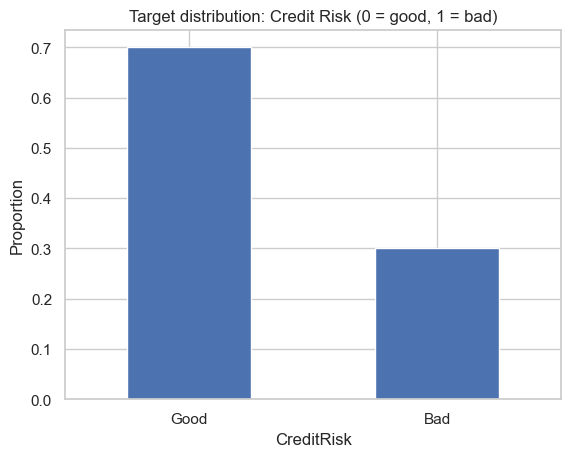

CreditRisk
0    0.7
1    0.3
Name: proportion, dtype: float64

In [17]:
# Check target distribution
df['CreditRisk'].value_counts(normalize=True).plot(kind="bar")
plt.title("Target distribution: Credit Risk (0 = good, 1 = bad)")
plt.xticks([0,1], ["Good", "Bad"], rotation=0)
plt.ylabel("Proportion")
plt.show()

df['CreditRisk'].value_counts(normalize=True)


### Target distribution

~70% good vs ~30% bad.  
Accuracy alone is not meaningful — we’ll rely on ROC AUC, precision, recall.  
For imbalance handling, models will be trained with class weights, and we may also compare with SMOTE to see if recall improves.


In [18]:
# Check datatypes and nulls
df.info()

# Quick look at unique counts per column (excluding target)
for col in df.columns:
    if col != "CreditRisk":
        print(f"{col}: {df[col].nunique()} unique values")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Status                 1000 non-null   object
 1   Duration               1000 non-null   int64 
 2   CreditHistory          1000 non-null   object
 3   Purpose                1000 non-null   object
 4   CreditAmount           1000 non-null   int64 
 5   Savings                1000 non-null   object
 6   Employment             1000 non-null   object
 7   InstallmentRate        1000 non-null   int64 
 8   SexAndStatus           1000 non-null   object
 9   OtherDetors            1000 non-null   object
 10  ResidenceSince         1000 non-null   int64 
 11  Property               1000 non-null   object
 12  Age                    1000 non-null   int64 
 13  OtherInstallmentPlans  1000 non-null   object
 14  Housing                1000 non-null   object
 15  ExistingCredits       

In [19]:
# 1. Auto-detect numeric vs categorical
num_cols_auto = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_auto = df.select_dtypes(include=["object"]).columns.tolist()

# Remove target from numeric
num_cols_auto = [c for c in num_cols_auto if c != "CreditRisk"]

print("Numeric columns:", num_cols_auto)
print("Categorical columns:", cat_cols_auto)

# 2. Compute cardinalities
cardinalities = {c: df[c].nunique() for c in cat_cols_auto}
print("\nCategorical cardinalities:")
for c, v in cardinalities.items():
    print(f"{c}: {v}")

# 3. Split categorical into simple vs complex (threshold = 3)
threshold = 3
simple_cat_cols = [c for c, v in cardinalities.items() if v <= threshold]
complex_cat_cols = [c for c, v in cardinalities.items() if v > threshold]

print("\nSimple categorical:", simple_cat_cols)
print("Complex categorical:", complex_cat_cols)


Numeric columns: ['Duration', 'CreditAmount', 'InstallmentRate', 'ResidenceSince', 'Age', 'ExistingCredits', 'PeopleLiable']
Categorical columns: ['Status', 'CreditHistory', 'Purpose', 'Savings', 'Employment', 'SexAndStatus', 'OtherDetors', 'Property', 'OtherInstallmentPlans', 'Housing', 'Job', 'Telephone', 'ForeignWorker']

Categorical cardinalities:
Status: 4
CreditHistory: 5
Purpose: 10
Savings: 5
Employment: 5
SexAndStatus: 4
OtherDetors: 3
Property: 4
OtherInstallmentPlans: 3
Housing: 3
Job: 4
Telephone: 2
ForeignWorker: 2

Simple categorical: ['OtherDetors', 'OtherInstallmentPlans', 'Housing', 'Telephone', 'ForeignWorker']
Complex categorical: ['Status', 'CreditHistory', 'Purpose', 'Savings', 'Employment', 'SexAndStatus', 'Property', 'Job']


In [20]:
# Check missing values
missing_summary = df.isna().sum()
print(missing_summary[missing_summary > 0])


Series([], dtype: int64)


### Missing values

No missing values detected.  
→ No imputation required for this dataset.



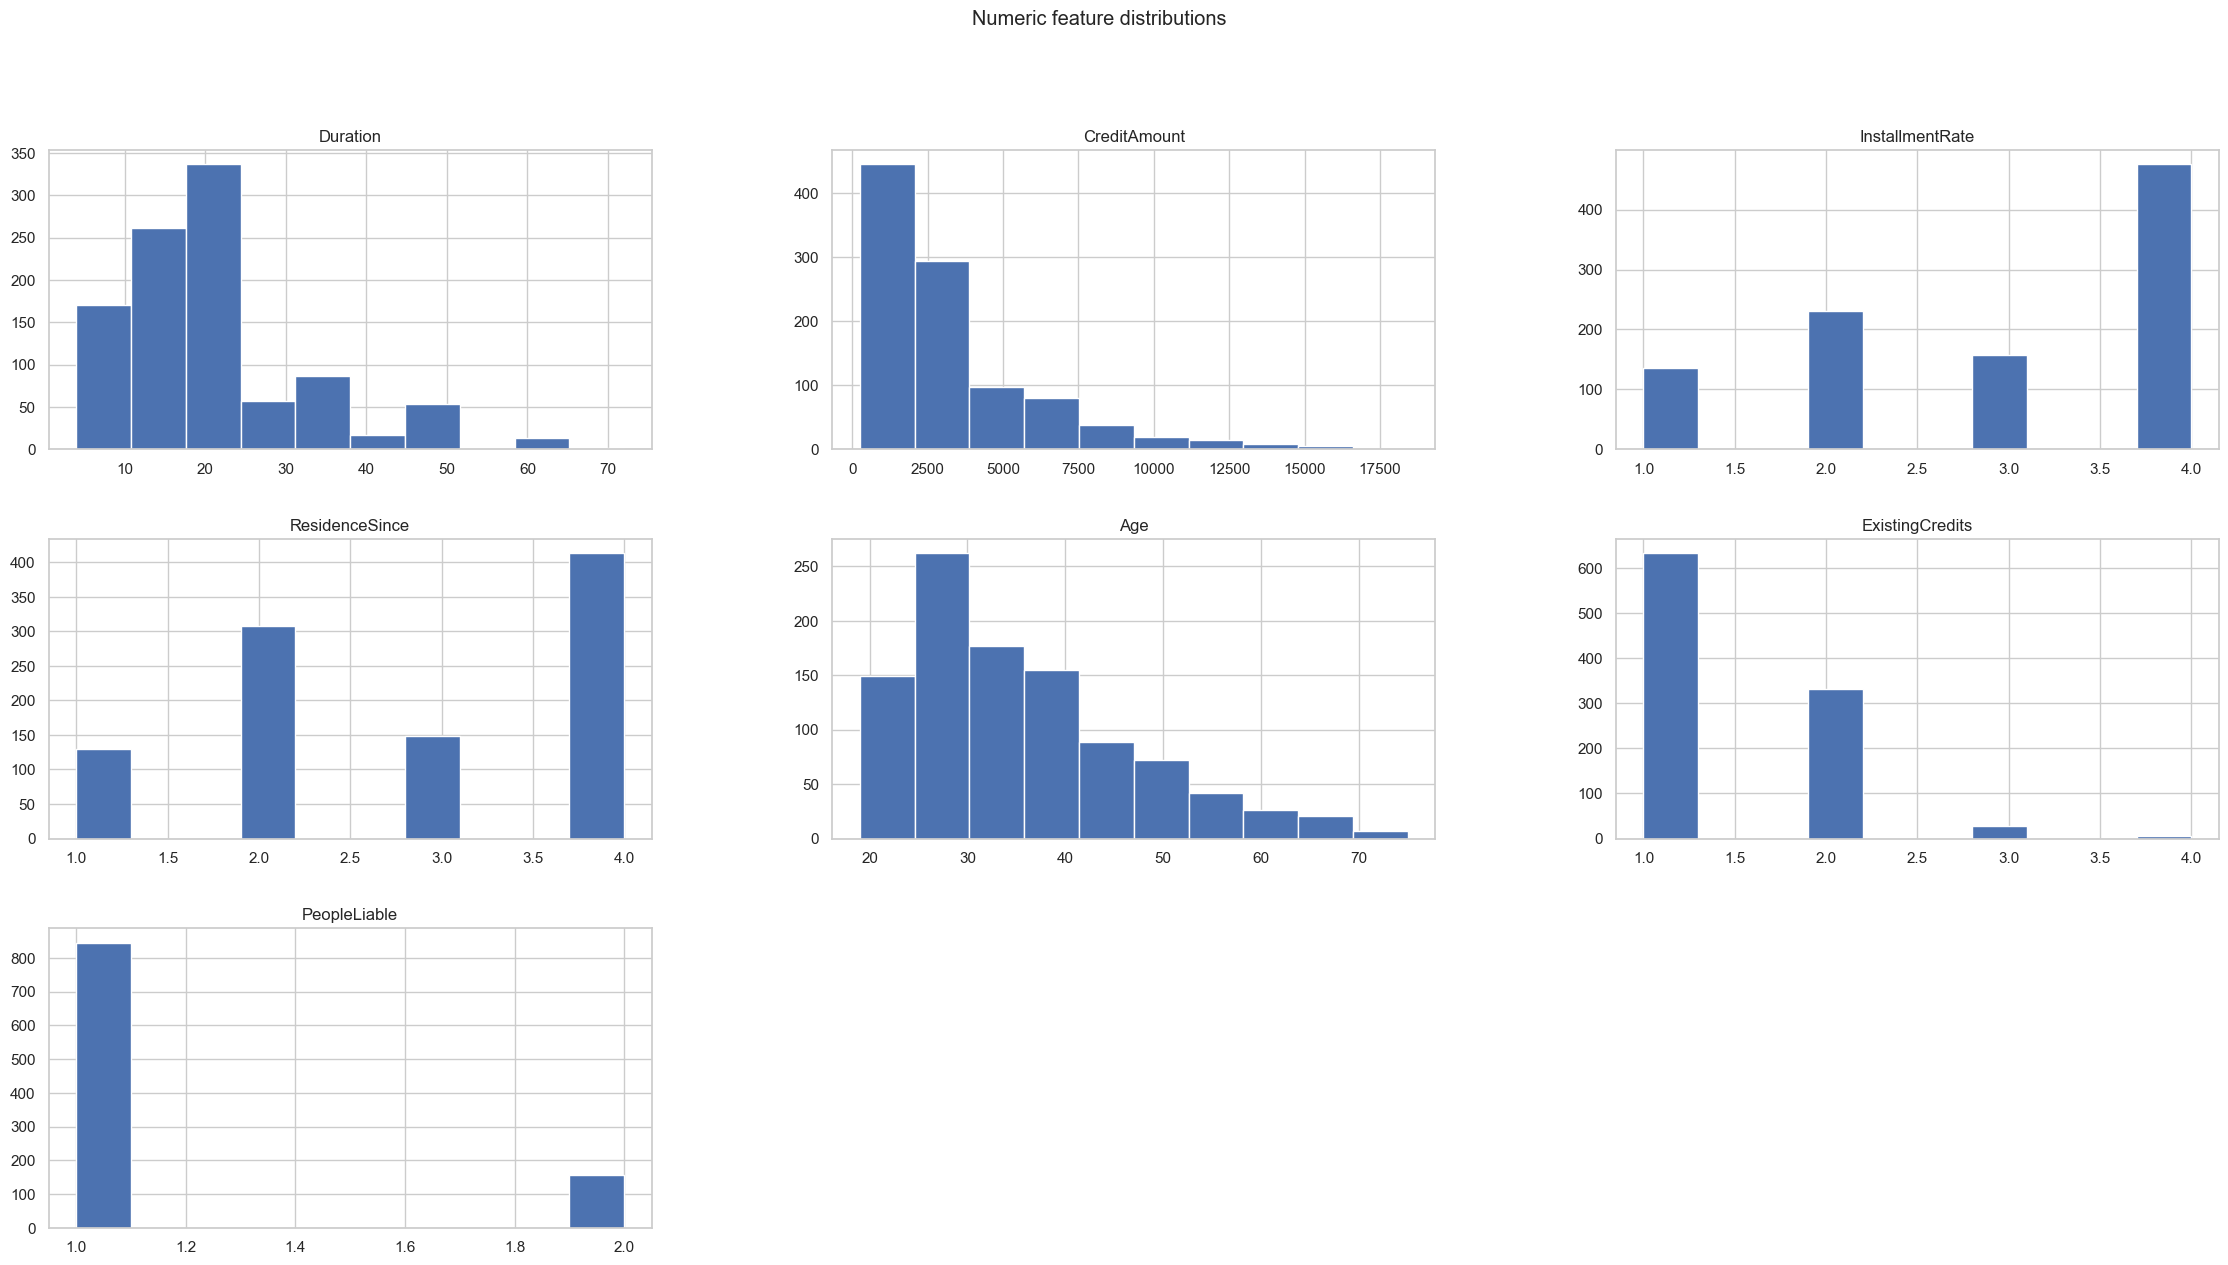

In [21]:
# Quick summary of numeric distributions
df[num_cols_auto].describe()

# Histograms
df[num_cols_auto].hist(figsize=(28,14))
plt.suptitle("Numeric feature distributions")
plt.show()


### Numeric feature distributions

- CreditAmount is right-skewed → scaling/log transform may help.  
- Age and Duration are more balanced.  
- Discrete numerics (InstallmentRate, ResidenceSince, ExistingCredits, PeopleLiable) can be treated as ordinal counts.


### Export feature groups

The feature group definitions (numeric, simple categorical, complex categorical)  
are saved to `configs/feature_groups.json`.  

This file serves as input for downstream pipeline components, ensuring consistent preprocessing across training and deployment.


In [22]:
# import json
# 
# feature_groups = {
#     "num_cols": num_cols_auto,
#     "simple_cat_cols": simple_cat_cols,
#     "complex_cat_cols": complex_cat_cols
# }
# 
# with open("../configs/feature_groups.json", "w") as f:
#     json.dump(feature_groups, f, indent=2)